In [1]:
# -*- coding: utf8 -*-

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
conf = SparkConf().setAppName("hospitalDiseaseWorr2vec")
sc = SparkContext(conf=conf)

In [3]:
sqlContext = SQLContext(sc)

In [4]:
import numpy as np
from gensim.models import Word2Vec
from medicalDataLoad import *

### 1. load入院数据

In [5]:
import pandas as pd
#829177
diaPath = "hospitalData/df_hospital_20171219_diseasematchKeywordNum.csv"
pd_dia = pd.read_csv(diaPath,  encoding='utf8').drop_duplicates()
pd_dia.shape

(56416, 33)

In [6]:
#print(pd_dia.columns)
#firstCode firstIndex firstType 映射，存储到文件中
def save2CodeType():
    pd_first = pd.read_csv("datasets/firstCode2Type.txt")
    code2TypeDict = dict()
    firstCodeList = pd_first["FirstCode"].tolist()
    firstCodeDict =  dict(zip(list(firstCodeList), range(0, len(firstCodeList) + 1)))
    firstTypeList = pd_first["FirstType"].tolist()
    for index in range(len(firstCodeList)):
        code2TypeDict[firstCodeList[index]] = firstTypeList[index] 
    #print("len=",len( pd_first["FirstCode"]))
    #print("res=",code2TypeDict)
    f = open("datasets/firstCode2Index2Type.txt", "w")
    for i in range(len(firstCodeList)):
        key = firstCodeList[i]
        print(str(key)+" "+ str(firstCodeDict[key])+" "+code2TypeDict[key])
        f.write(str(key)+" "+ str(firstCodeDict[key])+" "+code2TypeDict[key]+"\n" )
    f.flush()
    f.close()
#save2CodeType()

#### load一级分类index和名称词典

In [7]:
def loadCodeType(fileName):
    fileList = list(open(fileName,"r").readlines())
    #print(fileList)
    firstCode2IndexDict = dict()
    firstIndex2TypeDict = dict()
    for i in range(len(fileList)):
        itemArr = fileList[i].strip().split(" ")
        firstCode2IndexDict[itemArr[0]] = itemArr[1]
        firstIndex2TypeDict[itemArr[1]] = itemArr[2]
    return firstCode2IndexDict, firstIndex2TypeDict
fileName = "datasets/firstCode2Index2Type.txt"
firstCode2IndexDict, firstIndex2TypeDict = loadCodeType(fileName)
#print(firstCode2IndexDict)
print(firstIndex2TypeDict)

{'19': '疾病和死亡的外因', '18': '损伤、中毒和外因的某些其它后果', '11': '皮肤和皮下组织病', '15': '起源于围生期的某些情况', '1': '肿瘤', '20': '影响健康状态和保健机构接触的因素', '3': '内分泌、营养和代谢疾病', '16': '先天畸形、变性和染色体异常', '4': '精神和行为障碍', '14': '妊娠分娩及产褥期', '13': '泌尿生殖系统疾病', '10': '消化系统疾病', '7': '耳和乳突疾病', '6': '眼和附器疾病', '17': '症状、体症和临床与实验室异常所见，不可归类在他处者', '2': '血液及造血器官疾病和某些涉及免疫机制的疾患', '8': '循环系统疾病', '0': '某些传染病和寄生虫病', '9': '呼吸系统疾病', '12': '肌肉和骨骼系统和结缔组织疾病', '5': '神经系统疾病'}


### 2. 选取使用的字段

In [8]:
pd_dia_dis = pd_dia[["FirstCode","disease","chief_complaintKey","present_illnessKey","admission_situationKey","treat_processKey",
                     "discharge_situationKey","discharge_orderKey"]]
pd_dia_dis.head(3)

,FirstCode,disease,chief_complaintKey,present_illnessKey,admission_situationKey,treat_processKey,discharge_situationKey,discharge_orderKey
0,I00-I99,脑梗死,NaN,NaN,侧肢体无力 双侧 病理征 患者病情 伸舌居中 肌力肌张力 心慌胸闷 无恶心呕吐 查房 肢体抽...,侧肢体无力 双侧 病理征 患者病情 伸舌居中 肌力肌张力 心慌胸闷 无恶心呕吐 查房 肢体抽...,侧肢体无力 双侧 病理征 患者病情 伸舌居中 肌力肌张力 心慌胸闷 无恶心呕吐 查房 肢体抽...,侧肢体无力 双侧 病理征 患者病情 伸舌居中 肌力肌张力 心慌胸闷 无恶心呕吐 查房 肢体抽...
1,I00-I99,脑梗死,NaN,NaN,左侧 未见异常 切题 腱反射 病理反射阴性 右侧顶叶 CT 记忆力下降 伸舌 轮替动作 肢体...,脑梗死,入院 脑萎缩 血管动脉硬化 双侧脑室 空蝶鞍 化验结果 桥脑 大脑后动脉狭窄 放射冠区 对症...,脑梗死 脑萎缩 双膝 3. 脑动脉硬化 退行性骨关节炎 狭窄
2,I00-I99,脑梗死,NaN,NaN,双侧 查房 双侧瞳孔 浅感觉 无恶心呕吐 心律齐 伸舌居中 双肺呼吸音清 巴氏征阴性 等大 ...,双侧 查房 双侧瞳孔 浅感觉 无恶心呕吐 心律齐 伸舌居中 双肺呼吸音清 巴氏征阴性 等大 ...,双侧 查房 双侧瞳孔 浅感觉 无恶心呕吐 心律齐 伸舌居中 双肺呼吸音清 巴氏征阴性 等大 ...,双侧 查房 双侧瞳孔 浅感觉 无恶心呕吐 心律齐 伸舌居中 双肺呼吸音清 巴氏征阴性 等大 ...


#### list数据按比例随机切分

In [9]:
#随机按照指定的比例切分训练集合和测试集合
def doDatasetSplit(x,x_admin, y, test_size):
    X_num=len(x)
    train_index=[ i for i in range(X_num)]
    #print(train_index)
    test_index=[]
    test_num=int(X_num*test_size)
    print("test=",test_num)
    #随机选取index
    for i in range(test_num):
        randomIndex=int(np.random.uniform(0,len(train_index)))
        if randomIndex not in train_index:
            continue
        test_index.append(train_index[randomIndex])
        #print(randomIndex)
        train_index.remove(randomIndex)
    #train,test的index是抽取的数据集X的序号
    x_disease_train = [x[item] for item in train_index]
    x_admin_train = [x_admin[item] for item in train_index]
    x_disease_test = [x[item] for item in test_index]
    x_admin_test = [x_admin[item] for item in test_index]
    
    y_train = [y[item] for item in train_index]
    y_test = [y[item] for item in test_index]

    return x_disease_train, x_admin_train, x_disease_test,x_admin_test, y_train, y_test

### 2.全量数据集合切分成训练集和测试集

In [10]:
#1.load all datasets  2.do split on each first type datasets 3.merge to a final train and test sets 4.word to vector 5.do rf train and test
#1.load all dataset pd_dia_dis
def classifyDatasetsTF(pd_dia_dis,columnName, rate):
    x_disease_trainAll = list()
    x_admin_trainAll = list()
    x_disease_testAll = list()
    x_admin_testAll = list()
    y_trainAll = list()
    y_testAll = list()
    
    for item in firstCode2IndexDict.keys():
        #2.do split oon each first type, disease and admission_situation
        print("item=", item,firstCode2IndexDict[item])
        pd_tmp = pd_dia_dis[pd_dia_dis["FirstCode"]==item]
        x_disease = pd_tmp['disease'].tolist()
        print("dis num=",len(x_disease))
        x_admin = pd_tmp[columnName].tolist()
        #x_admin = pd_tmp["admission_situationKey"].tolist()
        label = firstCode2IndexDict[item]
        nums = len(x_disease)
        if nums==0:
            continue
        y = [label]*nums
        x_disease_train, x_admin_train, x_disease_test,x_admin_test, y_train, y_test = doDatasetSplit(x_disease,x_admin, y, rate)
        #3.merge 
        x_disease_trainAll.extend(x_disease_train)
        x_admin_trainAll.extend(x_admin_train)
        x_disease_testAll.extend(x_disease_test)
        x_admin_testAll.extend(x_admin_test)
        y_trainAll.extend(y_train)
        y_testAll.extend(y_test)
    print("train size=", len(y_trainAll), "test size=", len(y_testAll))
    print("sum=",len(y_trainAll)+len(y_testAll))
        
    return x_disease_trainAll, x_admin_trainAll,x_disease_testAll,x_admin_testAll, y_trainAll, y_testAll
rate = 0.2
columnName = "admission_situationKey"
x_disease_trainAll, x_admin_trainAll,x_disease_testAll,x_admin_testAll, y_trainAll, y_testAll = classifyDatasetsTF(pd_dia_dis,columnName,rate)

item= V01-Y98 19
dis num= 11
test= 2
item= KOO-K93 10
dis num= 5822
test= 1164
item= Q00-Q99 16
dis num= 451
test= 90
item= A00-B99 0
dis num= 3396
test= 679
item= P00-P96 15
dis num= 465
test= 93
item= L00-L99 11
dis num= 612
test= 122
item= F01-F99 4
dis num= 164
test= 32
item= J00-J99 9
dis num= 2800
test= 560
item= D50-D89 2
dis num= 542
test= 108
item= R00-R99 17
dis num= 3160
test= 632
item= C00-D48 1
dis num= 8705
test= 1741
item= N00-N99 13
dis num= 3380
test= 676
item= M00-M99 12
dis num= 1773
test= 354
item= E00-E90 3
dis num= 1347
test= 269
item= Z00-Z99 20
dis num= 2698
test= 539
item= O00-O99 14
dis num= 2619
test= 523
item= G00-G99 5
dis num= 1861
test= 372
item= I00-I99 8
dis num= 12769
test= 2553
item= S00-T98 18
dis num= 1718
test= 343
item= H60-H95 7
dis num= 281
test= 56
item= H00-H59 6
dis num= 1842
test= 368
train size= 46287 test size= 10129
sum= 56416


In [11]:
#构造fastText的训练样本和测试样本
def doPrepareFastText(x_disease_trainAll, x_admin_trainAll, y_trainAll,x_disease_testAll,x_admin_testAll,y_testAll , filePathTrain,filePathTest,filePathTestFeature,filePathTestLabel):
    fTrain = open(filePathTrain, "w")
    fTest = open(filePathTest,"w")
    fTestFeature = open(filePathTestFeature,"w")
    fTestLable = open(filePathTestLabel,"w")
    for i in range (len(x_disease_trainAll)):
        dis = x_disease_trainAll[i]
        adm = x_admin_trainAll[i]
        y_train = y_trainAll[i]
        #print("%d " %(y_train))
        y_trainStr = ("%s " %(y_train))
        featureStrTrain = ("%s%s" %(str(dis)+" " + str(adm) + " __label__", y_trainStr))
        fTrain.write(str(featureStrTrain)+"\n")
    fTrain.flush()
    fTrain.close()
    
    for i in range(len(x_disease_testAll)):
        disTest = x_disease_testAll[i]
        admTest = x_admin_testAll[i]
        y_test = y_testAll[i]
        y_testStr = ("%s " %(y_test))
        featureStrTest = ("%s%s" %(str(disTest)+" " + str(admTest) + " __label__", y_testStr))
        fTest.write(str(featureStrTest)+"\n")
        featureStrTestF = ("%s" %(str(disTest)+" " + str(admTest) + " "))
        fTestFeature.write(str(featureStrTestF)+"\n")
        featureStrTestL = ("%s%s" %("__label__", y_testStr))
        fTestLable.write(str(featureStrTestL)+"\n")
    
    fTestFeature.flush()
    fTestFeature.close()
    fTestLable.flush()
    fTestLable.close()
filePathTrain = "datasets/fastText.train"
filePathTestFeature = "datasets/fastTextFeature.test"
filePathTestLabel = "datasets/fastTextLabel.test"
filePathTest = "datasets/fastText.test"
doPrepareFastText(x_disease_trainAll, x_admin_trainAll, y_trainAll,x_disease_testAll,x_admin_testAll,y_testAll , filePathTrain,filePathTest,filePathTestFeature,filePathTestLabel )

In [12]:
#构造CNN的训练样本和测试样本
def doPrepareCNN(x_disease_trainAll, x_admin_trainAll, y_trainAll, filePath):
    f = open(filePath+".feature", "w")
    f_label =open(filePath+".label" ,"w")
    for i in range (len(x_disease_trainAll)):
        dis = x_disease_trainAll[i]
        adm = x_admin_trainAll[i]
        y_train = y_trainAll[i]
        
        y_trainStr = ("%s " %(y_train))
        #featureStr = ("%s%s" %(str(dis)+" " + str(adm) + " __label__", y_trainStr))
                               
        featureStr = ("%s" %(str(dis)+" " + str(adm)))
        labelStr = ("%s" %(y_trainStr))
        f.write(str(featureStr)+"\n")
        f_label.write(labelStr+"\n")
    f.flush()
    f.close()

filePath = "cnnModel/datasets/train"
#doPrepareCNN(x_disease_trainAll, x_admin_trainAll, y_trainAll, filePath )
filePathtest = "cnnModel/datasets/test"
#doPrepareCNN(x_disease_testAll,x_admin_testAll,y_testAll, filePathtest )

#### 输入分词后文本，产出向量均值

In [13]:
#4.word2vec
def keyWord2Vec(word, model,vector_size):
    disNoList = list()
    test_docs = word.split(" ")
    vecSum=np.zeros(vector_size)
    realLen =0
    for word in test_docs:
        try:
            #print(word)
            vecTmp = model[word]
            vecSum += vecTmp
            realLen +=1
        except KeyError:
            disNoList.append(word)
    #print("vec=",vecSum)
    return vecSum*1.0/realLen

In [14]:
#caculate the vertor, do average
from pyspark.mllib.regression import LabeledPoint
keyNum = 20
def datasetsFormatAve(x_disease_trainAll, x_admin_trainAll, y_trainAll, word2vec_model, vector_size):
    formatList = list()
    adminVec=np.zeros(vector_size)
    for i in range(len(x_disease_trainAll)):
        label = y_trainAll[i]
        
        vecRow = ""
        realKeyWord = 0
        dis = x_disease_trainAll[i]
        if(len(x_admin_trainAll)>0):
            admin = x_admin_trainAll[i]      
            if str(admin).lower() == 'nan':
                continue
            #4.word2vec
            adminVec = keyWord2Vec(admin,word2vec_model,vector_size)
        if not dis in word2vec_model.wv:
            continue
        disVec = keyWord2Vec(dis,word2vec_model,vector_size)
        vecRow = (disVec + adminVec)*1.0/2 
     
        row = LabeledPoint(label, vecRow)
        formatList.append(row)
    trainRDD = sc.parallelize(formatList)
    
    return trainRDD
#vector_size = 100
#trainRDD = datasetsFormatAve(x_disease_trainAll, x_admin_trainAll, y_trainAll, word2vec_model, vector_size)
#testRDD = datasetsFormatAve(x_disease_testAll,x_admin_testAll,y_testAll, word2vec_model,vector_size)

In [15]:
#concat all the vectors ,it's very large
from pyspark.mllib.regression import LabeledPoint
keyNum = 20
def datasetsFormat(x_disease_trainAll, x_admin_trainAll, y_trainAll, word2vec_model, vector_size):
    formatList = list()
    for i in range(len(x_disease_trainAll)):
        #print(i)
        vecRow = ""
        realKeyWord = 0
        dis = x_disease_trainAll[i]
        admin = x_admin_trainAll[i]
       
        if str(admin).lower() == 'nan':
            continue
        adminArr = admin.strip().split(" ")
        label = y_trainAll[i]
        if not dis in word2vec_model.wv:
            continue
        #select 20 admin keeywords
        minKeyNum = min(len(adminArr), keyNum)
        for index in range(minKeyNum):
            ad = adminArr[index]
            if ad in word2vec_model.wv:
                adVec = word2vec_model.wv[ad]
                adVecStr = [str(item) for item in adVec]
                vecRow = vecRow + " ".join(adVecStr)+" "
                realKeyWord += 1
        #print("index=",index)
        #如果关键字数量不足，补空值
        adVecStrTmp = [str(0) for i in range(vector_size)]
        while realKeyWord<keyNum:
            vecRow = vecRow + " ".join(adVecStrTmp)+" "
            realKeyWord +=1
        #将disease的vec向量和20个关键字向量拼接
        vec = word2vec_model.wv[dis]
        vecStr = [str(item) for item in vec]
        vecRow = " ".join(adVecStr)+" "+ vecRow
        tmp = vecRow.strip().split(" ")
   
        row = LabeledPoint(label, vecRow.strip().split(" "))
        formatList.append(row)
    trainRDD = sc.parallelize(formatList)
    
    return trainRDD
#trainRDD = datasetsFormat(x_disease_trainAll, x_admin_trainAll, y_trainAll, word2vec_model)
#testRDD = datasetsFormat(x_disease_testAll,x_admin_testAll,y_testAll, word2vec_model)

### 3.数据集向量化

In [16]:
#get the train datasets and test datasets
def datasetsFormatAll(x_disease_trainAll, x_admin_trainAll,x_disease_testAll,x_admin_testAll, y_trainAll, y_testAll, word2vec_model,vector_size):
    trainRDD = datasetsFormat(x_disease_trainAll, x_admin_trainAll, y_trainAll, word2vec_model,vector_size)
    testRDD = datasetsFormat(x_disease_testAll,x_admin_testAll,y_testAll, word2vec_model,vector_size)
    return trainRDD, testRDD
#trainRDD, testRDD = datasetsFormatAll(x_disease_trainAll, x_admin_trainAll,x_disease_testAll,x_admin_testAll, y_trainAll, y_testAll, word2vec_model,vector_size)

In [17]:
#get the train datasets and test datasets
def datasetsFormatAllAve(x_disease_trainAll, x_admin_trainAll,x_disease_testAll,x_admin_testAll, y_trainAll, y_testAll, word2vec_model, vector_size):
    trainRDD = datasetsFormatAve(x_disease_trainAll, x_admin_trainAll, y_trainAll, word2vec_model, vector_size)
    testRDD = datasetsFormatAve(x_disease_testAll,x_admin_testAll,y_testAll, word2vec_model, vector_size)
    return trainRDD, testRDD
#modelName = "model/word2VecModelsh.bin10_100_1e-05_15"
#savePath  = "datasets/w2v_rf_model2"
#word2vec_model = Word2Vec.load(modelName) 
#vector_size = 100
#trainRDD, testRDD = datasetsFormatAllAve(x_disease_trainAll, x_admin_trainAll,x_disease_testAll,x_admin_testAll, y_trainAll, y_testAll, word2vec_model, vector_size)

### 4.随机森林模型训练和测试

In [18]:
#RF model train and test
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils
from time import time

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

from ModelVisualization import *
def doRFrain(trainRDD, testRDD,savePath):
    maxTreeDepth = 4#5#5   #树的深度
    numTrees = 50#100
    numClass = 21
    t0 = time()
    # Train a RandomForest model.
    #  Empty categoricalFeaturesInfo indicates all features are continuous.
    #  Note: Use larger numTrees in practice.
    #  Setting featureSubsetStrategy="auto" lets the algorithm choose.
    model = RandomForest.trainClassifier(trainRDD, numClasses=numClass, categoricalFeaturesInfo={},
                                     numTrees=numTrees, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=maxTreeDepth, maxBins=32)
 
    tt = time() - t0
    print ("RandomForest Classifier trained in {} seconds".format(round(tt,3)))
    
    # Evaluate model on test instances and compute test error
    predictions = model.predict(testRDD.map(lambda x: x.features))
    labelsAndPredictions = testRDD.map(lambda lp: lp.label).zip(predictions)
    testErr = labelsAndPredictions.filter(
        lambda lp: lp[0]== lp[1]).count() / float(testRDD.count())
    print('Test Accuracy = ' + str(testErr))
    
    true_label = testRDD.map(lambda lp: lp.label).collect()
    predict_label = predictions.collect()
    #输出Kappa系数
    print("kappa_score = ", cohen_kappa_score(true_label,predict_label))
    #输出分类报告
    print("Print classificatioin report:")
    print(classification_report(true_label,predict_label))
    #输出原始的混淆矩阵
    print("Confusion matrix:")
    #print(confusion_matrix(true_label,predict_label))
    #输出混淆矩阵的优化显示
    matrixDisplay(confusion_matrix(true_label,predict_label))
    #输出F-score和每类样本数量的对比条形图
    print("Print precisiion recall and F1-SCORE")
    precision_list, recall_list, f_list, key_list, true_count_list = testPrecision(predict_label, true_label)
    comparisonPlot(key_list,f_list,true_count_list)
    #print(model.toDebugString()) 
    #model.save(sc, savePath)
    return model


#### 训练模型测试

rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/user/root/datasets/w2v_rf_model2/': No such file or directory
RandomForest Classifier trained in 19.27 seconds
Test Accuracy = 0.7945556761021797
kappa_score =  0.764581799213
Print classificatioin report:
             precision    recall  f1-score   support

        0.0       1.00      0.87      0.93       623
        1.0       0.97      0.99      0.98      1538
        2.0       0.00      0.00      0.00        96
        3.0       1.00      0.01      0.02       236
        4.0       0.00      0.00      0.00        28
        5.0       1.00      0.73      0.84       339
        6.0       1.00      0.81      0.89       328
        7.0       0.00      0.00      0.00        51
        8.0       0.81      0.99      0.89      2311
        9.0       1.00      0.18      0.30       509
       10.0       0.42      0.95      0.58      1043
       11.0       1.00      0.45      0.62       107
       12.0       1.00      0.77      0.87       320

/opt/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


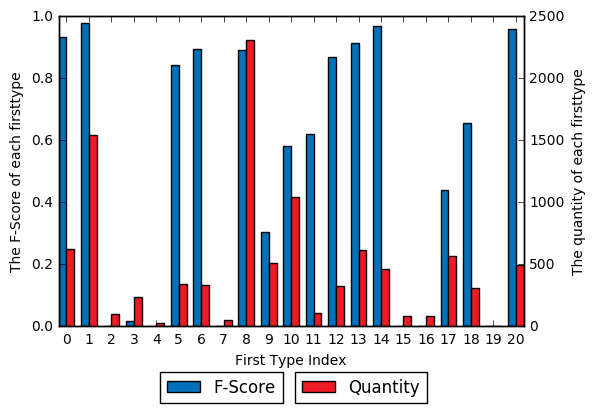

In [19]:
def doRFTrainTest():
    modelName = "model/word2VecModelsh.bin10_100_1e-05_15"
    savePath  = "datasets/w2v_rf_model2"
    !hadoop fs -rmr /user/root/datasets/w2v_rf_model2/
    word2vec_model = Word2Vec.load(modelName) 
    vector_size = 100
    trainRDD = datasetsFormatAve(x_disease_trainAll, x_admin_trainAll, y_trainAll, word2vec_model, vector_size)
    testRDD = datasetsFormatAve(x_disease_testAll,x_admin_testAll,y_testAll, word2vec_model,vector_size)
    rfModel = doRFrain(trainRDD, testRDD,savePath)
    rfModel.save(sc, savePath)
    return rfModel
rfModel = doRFTrainTest()

#### 模型预测，输入向量list，转化成spark 的DataFrame，计算预测结果

In [19]:
def RFPredict(rfModel, inListKey):
    inRDD = sc.parallelize(inListKey) 
    predict = rfModel.predict(inRDD)
    for item in predict.collect():
        print (int(item), firstIndex2TypeDict[str(int(item))])
    res = [firstIndex2TypeDict[str(int(item))] for item in predict.collect()]
    print(res)
    return  predict

In [33]:
def testRFKeyword():
    inList = list()   
    inStr1 = "癫痫 颈软 抽搐"#神经系统疾病
    inList.append(inStr1)
    inStr2 = "流涕 惊厥 皮疹 腹泻 消退 睡眠 呕吐 发热" #0
    inList.append(inStr2)
    inStr3 = "虹膜异色  IOL植入术 左眼"#眼和附器疾病
    inList.append(inStr3)
    inStr4 = "脑梗死 视物不清 双侧瞳孔 心肺听诊 肌力肌张力 肢体活动 无恶心呕吐 视野缺损 等大 等圆 无压痛 查体 左眼 神志 不灵 食欲 未及 头晕 "#循环系统疾病
    inList.append(inStr4)
    inStr5="肺呼吸音 3月 术后切口愈合 右偏 入院查体 未触及 病理性杂音 感压 颈软 瓣膜听诊区 心前区 恶性肿瘤术后 湿性啰音"#循环系统疾病
    inList.append(inStr5)
    inStr6 = "畸形 无压痛 右肺癌 肺呼吸音 双肺 查体 听诊 肿大 分泌物 右肺 蜘蛛痣 未见异常 黄染 转移 切题 脾未触及"#1肿瘤
    inList.append(inStr6)
    inStr7="直腿抬高试验 坐骨神经牵拉试验 加强实验 四字 试验 黄染 局部压痛 双肺呼吸音清 右下肢 反跳痛"#15
    inList.append(inStr7)

    savePath  = "datasets/w2v_rf_model2"
    rfModel = RandomForestModel.load(sc, savePath)
    res = RFPredict(rfModel, inList)
testRFKeyword()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 21.0 failed 1 times, most recent failure: Lost task 3.0 in stage 21.0 (TID 63, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/hdp/2.6.1.0-129/spark2/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/usr/hdp/2.6.1.0-129/spark2/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/hdp/2.6.1.0-129/spark2/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/hdp/2.6.1.0-129/spark2/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'str'> into Vector

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1925)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1951)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1965)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:936)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:935)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/hdp/2.6.1.0-129/spark2/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/usr/hdp/2.6.1.0-129/spark2/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/hdp/2.6.1.0-129/spark2/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/hdp/2.6.1.0-129/spark2/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'str'> into Vector

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


#### 输入原始的disease字段和入院情况字段，输出向量

In [25]:

def doPrepareSourceDiseaseAndAdminAve(dis, admin, word2vec_model,vector_size):
    adminKey = getKeyWordFromSource(admin)
    disVec = keyWord2Vec(dis,word2vec_model,vector_size)
    adminVec = keyWord2Vec(adminKey,word2vec_model,vector_size)
    vecRow = (disVec + adminVec)*1.0/2 
    return vecRow

## 输入原始数据，输出分类结果，即标签

In [30]:
def testRFSource():
    vector_size = 100
    modelName = "model/word2VecModelsh.bin10_100_1e-05_15"
    word2vec_model = Word2Vec.load(modelName) 
    
    inListKey = list()
    inSource1Dis = "脑梗死"#8
    inSource1Adm = "伸舌居中。颈软，无抵抗感，脑膜刺激征（-），心肺听诊无异常。右侧肢体肌力4+级，生理反射存在，病理征未引出。2015-02-23头颅MRI示脑梗死"
    inListKey.append(doPrepareSourceDiseaseAndAdminAve(inSource1Dis,inSource1Adm, word2vec_model, vector_size ))
    
    inSource2Dis = "胃恶性肿瘤"#肿瘤
    inSource2Adm = "患者1年半（2015年1月）前无明显原因及诱因出现上腹疼痛，后就诊于当地医院，行上腹部CT及胃镜检查，诊断“胃癌”，遂行胃癌手术治疗(具体手术范围不详)，术中发现肝脏转移结节，术后病理示“胃高分化腺癌”，术后未行放化疗，病情好转出院。患者于1月前无明显原因及诱因出现胸闷不适，无心悸、胸痛及肩背部放射痛，无发热、咳嗽、咳痰、咯血。为求进一步治疗就诊于我院，门诊以“胃癌术后”收入我科，患者自发病以来，神志清，精神好，饮食睡眠一般，大小便正常。"
    inListKey.append(doPrepareSourceDiseaseAndAdminAve(inSource2Dis,inSource2Adm,word2vec_model, vector_size ))
    
    #inSource2Dis = "盆腔结缔组织良性肿瘤"#1
    #inSource2Adm = "查体发现盆腔包块4天。T36.8℃，P80次/分，R20次/分，BP130/80mmHg。肿瘤，心界无扩大，心音有力，律齐，心率80次/分，各瓣膜区未闻及病理性杂音。腹胀，无压痛、无反跳痛，肝脾肋下未及，全腹无明显肿块，双肾区未及明显叩击痛，无移动性浊音，肠鸣音正常。脊柱无畸形，四肢无畸形，无浮肿。膝腱反射正常，巴氏征：未引出。外阴发育正常，阴道通畅，分泌物少，宫颈萎缩，宫体后位，萎缩，无压痛，左后方可扪及大小约5*3cm大小包块，活动度可，双侧附件区未触及明显包块及压痛。查体发现盆腔包块4天。"
    #inListKey.append(doPrepareSourceDiseaseAndAdminAve(inSource2Dis,inSource2Adm, word2vec_model, vector_size ))
    savePath  = "datasets/w2v_rf_model2"
    rfModel = RandomForestModel.load(sc, savePath)
    res = RFPredict(rfModel, inListKey)

testRFSource()

8 循环系统疾病
1 肿瘤
['循环系统疾病', '肿瘤']


#### 输入关键字字符串，输出向量

In [23]:
def key2vector(inStr ,word2vec_model,vector_size):
    inStrArr = inStr.strip().split(" ")
    dis = inStrArr[0]
    admin = " ".join(inStrArr[1:])
    #print(admin)
    disVec = keyWord2Vec(dis,word2vec_model,vector_size)
    adminVec = keyWord2Vec(admin,word2vec_model,vector_size)
    vecRow = (disVec + adminVec)*1.0/2 
    return vecRow

#### 输入测试样本和测试标签，输出测试集合准确率

In [ ]:
def testFileAccuracy(testPath, testLabel, word2vec_model, vector_size, rfModel):
    featureList = list(open(testPath,"r").readlines())
    labelList = list(open(testLabel, "r").readlines())
    
    featureVec = [key2vector(item ,word2vec_model, vector_size) for item in featureList]
    inRDD = sc.parallelize(np.array(featureVec))
    predict = rfModel.predict(inRDD)
    predict_label = predict.collect()
    predict_ = [str(int(item)).strip() for item in predict_label]
    label_ = [labelList[i].strip() for i in range(len(labelList)) ]
    #计算预测正确的数量

    res = [i for i in range(len(label_)) if label_[i]==predict_[i]]
    print("预测准确的样本数量为:" ,len(res))
    print("总的样本数量为：" ,len(label_))
    print("测试集合准确率为：" ,len(res)*1.0/len(label_))
    return predict_label
vector_size = 100
modelName = "model/word2VecModelsh.bin10_100_1e-05_15"
savePath  = "datasets/w2v_rf_model2"

word2vec_model = Word2Vec.load(modelName)   
rfModel = RandomForestModel.load(sc, savePath)

testPath = "cnnModel/datasets/test.feature"
testLabel = "cnnModel/datasets/test.label"
predict_label = testFileAccuracy(testPath, testLabel, word2vec_model, vector_size, rfModel)

预测准确的样本数量为: 7981
总的样本数量为： 10141
测试集合准确率为： 0.787003254116951


### 针对不同的word2vec模型，训练随机森林模型 

../icd10/model/word2VecModelsh.bin5_100_1e-05_10
RandomForest Classifier trained in 4.351 seconds
Test Accuracy = 0.8885027799841144
kappa_score =  0.873410366902
Print classificatioin report:
             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99       611
        1.0       0.99      1.00      1.00      1527
        2.0       0.00      0.00      0.00        98
        3.0       0.00      0.00      0.00       247
        4.0       0.00      0.00      0.00        28
        5.0       1.00      0.98      0.99       341
        6.0       1.00      0.91      0.95       323
        7.0       0.00      0.00      0.00        48
        8.0       0.88      0.99      0.93      2294
        9.0       0.93      0.86      0.89       497
       10.0       0.61      0.98      0.75      1052
       11.0       0.00      0.00      0.00       107
       12.0       0.97      0.98      0.97       313
       13.0       0.92      0.93      0.93       599
       14.0

/opt/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


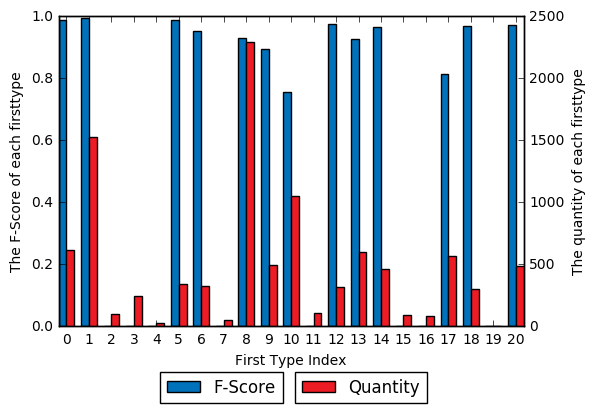

../icd10/model/word2VecModelsn.bin5_100_1e-05_10
RandomForest Classifier trained in 4.009 seconds
Test Accuracy = 0.8667593328038126
kappa_score =  0.84975044953
Print classificatioin report:
             precision    recall  f1-score   support

        0.0       0.99      0.92      0.95       611
        1.0       1.00      0.99      0.99      1527
        2.0       1.00      0.17      0.30        98
        3.0       1.00      0.34      0.51       247
        4.0       0.00      0.00      0.00        28
        5.0       1.00      0.71      0.83       341
        6.0       1.00      0.74      0.85       323
        7.0       0.00      0.00      0.00        48
        8.0       0.97      1.00      0.98      2294
        9.0       1.00      0.51      0.68       497
       10.0       0.87      0.99      0.93      1052
       11.0       0.00      0.00      0.00       107
       12.0       0.98      0.90      0.94       313
       13.0       0.47      1.00      0.64       599
       14.0 

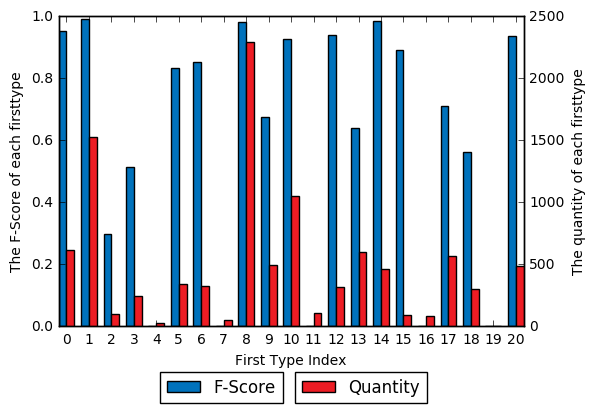

../icd10/model/word2VecModelsh.bin5_100_1e-05_15
RandomForest Classifier trained in 3.404 seconds
Test Accuracy = 0.8411437648927721
kappa_score =  0.817099027736
Print classificatioin report:
             precision    recall  f1-score   support

        0.0       1.00      0.91      0.95       611
        1.0       0.98      0.99      0.99      1527
        2.0       0.00      0.00      0.00        98
        3.0       0.00      0.00      0.00       247
        4.0       0.00      0.00      0.00        28
        5.0       1.00      0.94      0.97       341
        6.0       0.98      0.95      0.97       323
        7.0       0.00      0.00      0.00        48
        8.0       0.68      1.00      0.81      2294
        9.0       0.98      0.61      0.75       497
       10.0       0.72      0.95      0.82      1052
       11.0       0.00      0.00      0.00       107
       12.0       1.00      0.73      0.85       313
       13.0       0.90      0.93      0.91       599
       14.0

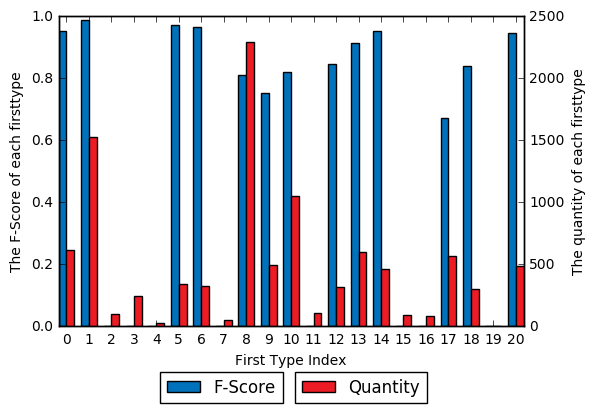

../icd10/model/word2VecModelsn.bin5_100_1e-05_15


In [ ]:
def testW2VRFresult(x_disease_trainAll, x_admin_trainAll, y_trainAll,x_disease_testAll,x_admin_testAll,y_testAll):
    window_size=5 ;negative=5 ;sample = 1e-6 ;iterNum = 10;vector_size=100;
    index = 0 
    model_dir = "../icd10/model/"
    #for window in range(7,10):
    for window in [ 5,10, 15,3]:
        index=0
        for vector_size in [ 100, 200, 100 ]:
            for sample in [ 1e-5, 1e-6]:
                for negative in [ 10 , 15]:
                    modelIndex = str(window)+"_"+str(vector_size)+"_"+str(sample)+"_"+str(negative)
                    for name in ["word2VecModelsh.bin","word2VecModelsn.bin"]:#,"word2VecModelch.bin","word2VecModelcn.bin"]:
                        modelName =model_dir +  name + modelIndex
                        word2vec_model = Word2Vec.load(modelName)    
                        trainRDD = datasetsFormatAve(x_disease_trainAll, x_admin_trainAll, y_trainAll, word2vec_model, vector_size)
                        testRDD = datasetsFormatAve(x_disease_testAll,x_admin_testAll,y_testAll, word2vec_model,vector_size)
                        #trainRDD, testRDD = datasetsFormatAll(x_trainAll, x_testAll, y_trainAll, y_testAll, word2vec_model)
                        print(modelName)
                        savePath=""
                        rfModel = doRFrain(trainRDD, testRDD,savePath)
#disease + admin keyword ，word2vec averange , rf classify
testW2VRFresult(x_disease_trainAll, x_admin_trainAll, y_trainAll, x_disease_testAll,x_admin_testAll,y_testAll)  
#disease
#testW2VRFresult(x_disease_trainAll, "", y_trainAll, x_disease_testAll,"",y_testAll)                                                                                       